# Drought frequencies in North and South Ghana

by Eszter Kovacs

In [1]:
import os
import numpy as np
import xarray as xr
import glob
import datetime
from datetime import datetime as dt
from pyhdf.SD import SD, SDC
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from stats_utils import get_dryspell


# CHIRPS

/opt/jaspy/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'Drought occurrences in North and South Ghana \nbetween 1981 and 2020 CHIRPS')

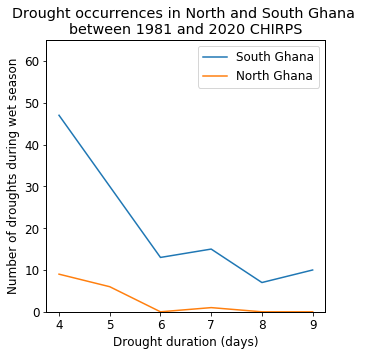

In [4]:
file = '/gws/pw/j05/cop26_hackathons/leeds/CHIRPS/W_Africa_chirps.nc'
rootgrp = Dataset(file, "r")
da = xr.DataArray(rootgrp.variables['precip'][:, :, :],
                     coords=[
                         ('time', rootgrp.variables['time']),
                         ('lat', rootgrp.variables['latitude']),
                         ('lon', rootgrp.variables['longitude']),
                     ])
# include only data over Ghana
smallds = da.where((da.lon>-3.38)*(da.lon<1.25)*(da.lat>4.5)*(da.lat<11.09), drop = True)

# wet seasons: North Ghana: JJAS, South Ghana: MAM and JASO
nwsstart = 151
nwsend = 274
sws1start = 59
sws1end = 152
sws2start = 181
sws2end = 305

# split into North and South Ghana at lat = 8.00 degrees
nsdivide =8
south = smallds.where(smallds.lat < nsdivide, drop = True)
north = smallds.where(smallds.lat >= nsdivide, drop = True)

# Count consecutive droughts
ndrought = north.mean(['lat', 'lon'])<1
ndroughts = [np.sum(ndrought[365*i : 365*(i+1)].data) for i in range(40)]

sdrought = south.mean(['lat', 'lon'])<1
sdroughts = [np.sum(sdrought[365*i : 365*(i+1)].data) for i in range(40)]

ncondition = ndrought.data
scondition = sdrought.data

ncons = [[0]]*35
scons = [[0]]*35
for i in range(35):
    ncond = ndrought[365*i + nwsstart : 365*i + nwsend].data
    ncons[i] = np.diff(np.where(np.concatenate(([ncond[0]],
                                     ncond[:-1] != ncond[1:],
                                     [True])))[0])[::2]
    scond1 = sdrought[365*i + sws1start : 365*i + sws1end].data
    scond2 = sdrought[365*i + sws2start : 365*i + sws2end].data
    s1 = np.diff(np.where(np.concatenate(([scond1[0]],
                                     scond1[:-1] != scond1[1:],
                                     [True])))[0])[::2]
    s2 = np.diff(np.where(np.concatenate(([scond2[0]],
                                     scond2[:-1] != scond2[1:],
                                     [True])))[0])[::2]
    scons[i] = np.concatenate([s1,s2])

# Plot drought frequencies
plt.figure(figsize = [5,5])

con10s = [np.concatenate(scons), np.concatenate(ncons)]
labels = ['South', 'North']
# font settings
s = 12
font = {'weight' : 'normal',
        'size'   : s,
        'serif': 'Arial'}

plt.rc('font', **font)
plt.rc('axes', linewidth=1)
for i,con in enumerate(con10s):
    hist = np.histogram(con, bins = 6, range = [3.5,9.5])
    plt.plot(np.arange(4,10), hist[0], label = labels[i] + ' Ghana');
plt.legend()
plt.ylim([0,65])
plt.xlabel('Drought duration (days)')
plt.ylabel('Number of droughts during wet season')
plt.title('Drought occurrences in North and South Ghana \nbetween 1981 and 2020 CHIRPS')

In [2]:
# from Leif Denby
pathname = '/gws/pw/j05/cop26_hackathons/leeds/'
from pathlib import Path
import xarray as xr

DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")

def make_cmip6_filepath(institute, model, scenario, variant, experiment, table_id, variable, grid, version, time_range, data_root=DATA_ROOT):
    """
    Make a file path for a cmip6 dataset for a single variable
    Historical runs (1850-2014) are in `/badc/cmip6/data/CMIP6/CMIP/<institute>/<model>/historical/<variant>/<table_id>/<variable>/<grid>/<version>/`
    Scenario runs are in `/badc/cmip6/data/CMIP6/ScenarioMIP/<institute>/<model>/<scenario_name>/<variant>/<table_id>/<variable>/<grid>/<version>/`
    `scenario_name` is likely to be one of ssp119, ssp126, ssp245, ssp370 or ssp585
    `variant` takes the form `r<realiation_id>0<initialization_id>0<physics_id>0<forcing_id>`, e.g. `r1i1p1f2`, where the numbers are the indexes for:  
    **r**ealization, **i**nitialization, **p**hysics, **f**orcing
    `table_id` generally indicates the frequency of the data, e.g. day, 3hr, Amon
    `grid` is the model grid being used, e.g. gn, where  
       * `gm`: global mean data  
       * `gn`: data reported on a model's native grid  
       * `gr1`: regridded data reported on a grid other than the native grid and other than the preferred target grid  
    It is likely the `grid` will be the native grid, i.e. `gn`
    `version` normally in the form `v[YYYYMMDD]` or `latest`, e.g. `v20200203
    
    `variable` generally follows the list on https://pcmdi.llnl.gov/mips/cmip3/variableList.html, for example 
       `tas`: air_temperature 
       `pr`: precipitation_flux
       `ts`: surface_temperature
    The following institutions have data in both historical and ScenarioMIPs:
    AS-RCEC, AWI, BCC, CAMS, CAS, CCCR-IITM, CCCma, CMCC, CNRM-CERFACS, CSIRO, CSIRO-ARCCSS, E3SM-Project, EC-Earth-Consortium, FIO-QLNM, HAMMOZ-Consortium, INM, IPSL, KIOST, MIROC, MOHC, MPI-M, MRI, NASA-GISS, NCAR, NCC, NIMS-KMA, NOAA-GFDL, NUIST, THU, UA
    """
    path = DATA_ROOT / scenario / institute / model / experiment / variant / table_id / variable / grid / version
    filename = f"{variable}_{table_id}_{model}_{experiment}_{variant}_{grid}_{time_range}.nc"
    
    return path / filename

# SSP585 (2040-2070)

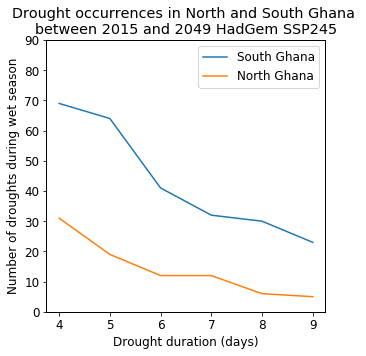

In [6]:
fp = make_cmip6_filepath(
    institute="MOHC", scenario="ScenarioMIP", model="HadGEM3-GC31-LL", experiment="ssp585", variant="r1i1p1f3",
    table_id="day", variable="pr", grid="gn", version="v20200114", time_range="20150101-20491230"
)

da = xr.open_dataset(fp)
da = da.pr.where((da.lon>=-3.5)*(da.lon<=1.25)*(da.lat>=5)*(da.lat<=11.09)*(da.time>=cftime.Datetime360Day(2040, 1, 1))*(da.time<cftime.Datetime360Day(2070, 1, 1)), drop = True)
da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
smallds = da*86400
                                                                         
da = xr.open_dataset(fp2)
da = da.pr.where((da.lon>=-3.5)*(da.lon<=1.25)*(da.lat>5)*(da.lat<11.09)*(da.time>=cftime.Datetime360Day(2040, 1, 1))*(da.time<cftime.Datetime360Day(2070, 1, 1)), drop = True)
da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')

smallds = xr.concat([smallds,da*86400], dim = 'time')

# wet seasons: North Ghana: JJAS, South Ghana: MAM and JASO
nwsstart = 151
nwsend = 274
sws1start = 59
sws1end = 152
sws2start = 181
sws2end = 305

# split into North and South Ghana at lat = 8.00 degrees
nsdivide =8.00
south = smallds.where(smallds.lat < nsdivide, drop = True)
north = smallds.where(smallds.lat > nsdivide, drop = True)

# Count consecutive droughts
ndrought = north.mean(['lat', 'lon'])<1
ndroughts = [np.sum(ndrought[365*i : 365*(i+1)].data) for i in range(35)]

sdrought = south.mean(['lat', 'lon'])<1
sdroughts = [np.sum(sdrought[365*i : 365*(i+1)].data) for i in range(35)]

ncondition = ndrought.data
scondition = sdrought.data

ncons = [[0]]*30
scons = [[0]]*30
for i in range(30):
    ncond = ndrought[365*i + nwsstart : 365*i + nwsend].data
    ncons[i] = np.diff(np.where(np.concatenate(([ncond[0]],
                                     ncond[:-1] != ncond[1:],
                                     [True])))[0])[::2]
    scond1 = sdrought[365*i + sws1start : 365*i + sws1end].data
    scond2 = sdrought[365*i + sws2start : 365*i + sws2end].data
    s1 = np.diff(np.where(np.concatenate(([scond1[0]],
                                     scond1[:-1] != scond1[1:],
                                     [True])))[0])[::2]
    s2 = np.diff(np.where(np.concatenate(([scond2[0]],
                                     scond2[:-1] != scond2[1:],
                                     [True])))[0])[::2]
    scons[i] = np.concatenate([s1,s2])

# Plot drought frequencies
plt.figure(figsize = [5,5])

con10s = [np.concatenate(scons), np.concatenate(ncons)]
labels = ['South', 'North']
# font settings
s = 12
font = {'weight' : 'normal',
        'size'   : s,
        'serif': 'Arial'}

plt.rc('font', **font)
plt.rc('axes', linewidth=1)
for i,con in enumerate(con10s):
    hist = np.histogram(con, bins = 6, range = [3.5,9.5])
    plt.plot(np.arange(4,10), hist[0], label = labels[i] + ' Ghana');
plt.legend()
plt.xlabel('Drought duration (days)')
plt.ylabel('Number of droughts during wet season')
plt.ylim([0,90])
plt.title('Drought occurrences in North and South Ghana \nbetween 2015 and 2049 HadGem SSP245')

plt.savefig('HadGemSSP245.png')

# SSP245 (2040-2070)

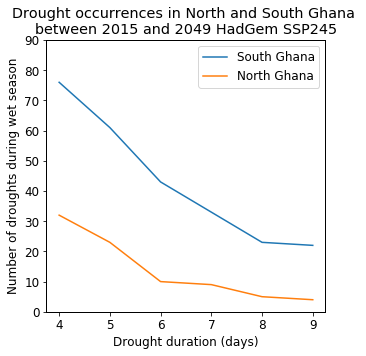

In [5]:
import os
import numpy as np
import xarray as xr
import glob
import datetime
from datetime import datetime as dt
from pyhdf.SD import SD, SDC
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime

# from Leif Denby
pathname = '/gws/pw/j05/cop26_hackathons/leeds/'
from pathlib import Path
import xarray as xr

DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")

fp = make_cmip6_filepath(
    institute="MOHC", scenario="ScenarioMIP", model="HadGEM3-GC31-LL", experiment="ssp245", variant="r1i1p1f3",
    table_id="day", variable="pr", grid="gn", version="v20190908", time_range="20150101-20491230"
)

fp2 = make_cmip6_filepath(
    institute="MOHC", scenario="ScenarioMIP", model="HadGEM3-GC31-LL", experiment="ssp245", variant="r1i1p1f3",
    table_id="day", variable="pr", grid="gn", version="v20190908", time_range="20500101-21001230"
)

da = xr.open_dataset(fp)
da = da.pr.where((da.lon>=-3.5)*(da.lon<=1.25)*(da.lat>=5)*(da.lat<=11.09)*(da.time>=cftime.Datetime360Day(2040, 1, 1))*(da.time<cftime.Datetime360Day(2070, 1, 1)), drop = True)
da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
smallds = da*86400
                                                                         
da = xr.open_dataset(fp2)
da = da.pr.where((da.lon>=-3.5)*(da.lon<=1.25)*(da.lat>5)*(da.lat<11.09)*(da.time>=cftime.Datetime360Day(2040, 1, 1))*(da.time<cftime.Datetime360Day(2070, 1, 1)), drop = True)
da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')

smallds = xr.concat([smallds,da*86400], dim = 'time')

# wet seasons: North Ghana: JJAS, South Ghana: MAM and JASO
nwsstart = 151
nwsend = 274
sws1start = 59
sws1end = 152
sws2start = 181
sws2end = 305

# split into North and South Ghana at lat = 8.00 degrees
nsdivide =8.00
south = smallds.where(smallds.lat < nsdivide, drop = True)
north = smallds.where(smallds.lat > nsdivide, drop = True)

# Count consecutive droughts
ndrought = north.mean(['lat', 'lon'])<1
ndroughts = [np.sum(ndrought[365*i : 365*(i+1)].data) for i in range(35)]

sdrought = south.mean(['lat', 'lon'])<1
sdroughts = [np.sum(sdrought[365*i : 365*(i+1)].data) for i in range(35)]

ncondition = ndrought.data
scondition = sdrought.data

ncons = [[0]]*30
scons = [[0]]*30
for i in range(30):
    ncond = ndrought[365*i + nwsstart : 365*i + nwsend].data
    ncons[i] = np.diff(np.where(np.concatenate(([ncond[0]],
                                     ncond[:-1] != ncond[1:],
                                     [True])))[0])[::2]
    scond1 = sdrought[365*i + sws1start : 365*i + sws1end].data
    scond2 = sdrought[365*i + sws2start : 365*i + sws2end].data
    s1 = np.diff(np.where(np.concatenate(([scond1[0]],
                                     scond1[:-1] != scond1[1:],
                                     [True])))[0])[::2]
    s2 = np.diff(np.where(np.concatenate(([scond2[0]],
                                     scond2[:-1] != scond2[1:],
                                     [True])))[0])[::2]
    scons[i] = np.concatenate([s1,s2])

# Plot drought frequencies
plt.figure(figsize = [5,5])

con10s = [np.concatenate(scons), np.concatenate(ncons)]
labels = ['South', 'North']
# font settings
s = 12
font = {'weight' : 'normal',
        'size'   : s,
        'serif': 'Arial'}

plt.rc('font', **font)
plt.rc('axes', linewidth=1)
for i,con in enumerate(con10s):
    hist = np.histogram(con, bins = 6, range = [3.5,9.5])
    plt.plot(np.arange(4,10), hist[0], label = labels[i] + ' Ghana');
plt.legend()
plt.xlabel('Drought duration (days)')
plt.ylabel('Number of droughts during wet season')
plt.ylim([0,90])
plt.title('Drought occurrences in North and South Ghana \nbetween 2015 and 2049 HadGem SSP245')

plt.savefig('HadGemSSP245.png')

# HadGem historical

Work in progress

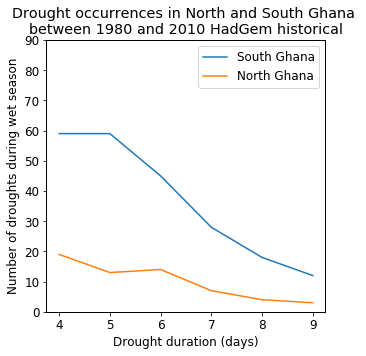

In [4]:
import os
import numpy as np
import xarray as xr
import glob
import datetime
from datetime import datetime as dt
from pyhdf.SD import SD, SDC
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime

# from Leif Denby
pathname = '/gws/pw/j05/cop26_hackathons/leeds/'
from pathlib import Path
import xarray as xr

DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")

fp = make_cmip6_filepath(
    institute="MOHC", scenario="CMIP", model="HadGEM3-GC31-LL", experiment="historical", variant="r1i1p1f3",
    table_id="day", variable="pr", grid="gn", version="v20190624", time_range="19500101-20141230"
)

da = xr.open_dataset(fp)
da = da.pr.where((da.lon>=-3.5)*(da.lon<=1.25)*(da.lat>=5)*(da.lat<=11.09)*(da.time>=cftime.Datetime360Day(1980, 1, 1))*(da.time<cftime.Datetime360Day(2010, 1, 1)), drop = True)
da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
smallds = da*86400
                                                                         
# wet seasons: North Ghana: JJAS, South Ghana: MAM and JASO
nwsstart = 151
nwsend = 274
sws1start = 59
sws1end = 152
sws2start = 181
sws2end = 305

# split into North and South Ghana at lat = 8.00 degrees
nsdivide =8.00
south = smallds.where(smallds.lat < nsdivide, drop = True)
north = smallds.where(smallds.lat > nsdivide, drop = True)

# Count consecutive droughts
ndrought = north.mean(['lat', 'lon'])<1
ndroughts = [np.sum(ndrought[365*i : 365*(i+1)].data) for i in range(35)]

sdrought = south.mean(['lat', 'lon'])<1
sdroughts = [np.sum(sdrought[365*i : 365*(i+1)].data) for i in range(35)]

ncondition = ndrought.data
scondition = sdrought.data

ncons = [[0]]*30
scons = [[0]]*30
for i in range(30):
    ncond = ndrought[365*i + nwsstart : 365*i + nwsend].data
    ncons[i] = np.diff(np.where(np.concatenate(([ncond[0]],
                                     ncond[:-1] != ncond[1:],
                                     [True])))[0])[::2]
    scond1 = sdrought[365*i + sws1start : 365*i + sws1end].data
    scond2 = sdrought[365*i + sws2start : 365*i + sws2end].data
    s1 = np.diff(np.where(np.concatenate(([scond1[0]],
                                     scond1[:-1] != scond1[1:],
                                     [True])))[0])[::2]
    s2 = np.diff(np.where(np.concatenate(([scond2[0]],
                                     scond2[:-1] != scond2[1:],
                                     [True])))[0])[::2]
    scons[i] = np.concatenate([s1,s2])

# Plot drought frequencies
plt.figure(figsize = [5,5])

con10s = [np.concatenate(scons), np.concatenate(ncons)]
labels = ['South', 'North']
# font settings
s = 12
font = {'weight' : 'normal',
        'size'   : s,
        'serif': 'Arial'}

plt.rc('font', **font)
plt.rc('axes', linewidth=1)
for i,con in enumerate(con10s):
    hist = np.histogram(con, bins = 6, range = [3.5,9.5])
    plt.plot(np.arange(4,10), hist[0], label = labels[i] + ' Ghana');
plt.legend()
plt.xlabel('Drought duration (days)')
plt.ylabel('Number of droughts during wet season')
plt.ylim([0,90])
plt.title('Drought occurrences in North and South Ghana \nbetween 1980 and 2010 HadGem historical')

plt.savefig('HadGemhistorical.png')